In [1]:
import numpy as np
import random
import time
import math
import doctest
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def J_quadratic(neuron, X, y):
    return 0.5 * np.mean((neuron.vectorized_forward_pass(X) - y) ** 2)

def J_quadratic_derivative(y, y_hat):
    return (y_hat - y) / len(y)

def compute_grad_analytically(neuron, X, y, J_prime=J_quadratic_derivative):  
    # Вычисляем активации
    # z - вектор результатов сумматорной функции нейрона на разных примерах
    
    z = neuron.summatory(X)
    y_hat = neuron.activation(z)

    # Вычисляем нужные нам частные производные
    dy_dyhat = J_prime(y, y_hat)
    dyhat_dz = neuron.activation_function_derivative(z)
    
    dz_dw = X

    grad = ((dy_dyhat * dyhat_dz).T).dot(dz_dw)
    
    # Сделаем из горизонтального вектора вертикальный
    grad = grad.T
    
    return grad

def cost_function(network, test_data, onehot=True):
    c = 0
    for example, y in test_data:
        if not onehot:
            y = np.eye(3, 1, k=-int(y))
        yhat = network.feedforward(example)
        c += np.sum((y - yhat)**2)
    return c / len(test_data)

In [3]:
class Neuron:
    
    def __init__(self, weights, activation_function=sigmoid, activation_function_derivative=sigmoid_prime):
        
        self.w = weights
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        
    def forward_pass(self, sigle_input):
        result = 0
        for i in range(self.w.size):
            result += float(self.w[i] * single_input[i])
        return self.activation_function(result)
    
    def summatory(self, input_matrix):
        return input_matrix.dot(self.w)
    
    def activation(self, summatory_activation):
        return self.activation_function(summatory_activation)
    
    def vectorized_forward_pass(self, input_matrix):
        return self.activation(self.summatory(input_matrix))
    
    def update_mini_batch(self, X, y, learning_rate, eps):
        nabla_j = compute_grad_analytically(self, X, y)
        j_old = J_quadratic(self, X, y)
        delta_w = -1 * learning_rate * nabla_j
        self.w += delta_w
        j_new = J_quadratic(self, X, y)

        if math.fabs(j_old - j_new) < eps:
            return 1
        else:
            return 0
    
    def SGD(self, X, y, batch_size, learning_rate=0.1, eps=1e-6, max_steps=200):
        indexes = list(range(len(X)))
        
        for s in range(max_steps):
            sample_ind = np.random.choice(indexes, batch_size, replace=False)
            X_example = X[sample_ind]
            y_answer = y[sample_ind]
            
            res = self.update_mini_batch(X_example, y_answer, learning_rate, eps)
            if res:
                return 1
        return 0

In [4]:
class Network:
    
    def __init__(self, sizes, output=True):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y,1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.output = output
        
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
       
        if test_data is not None: n_test = len(test_data)
        n = len(training_data)
        success_tests = 0
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data is not None and self.output:
                success_tests = self.evaluate(test_data)
                print("Процент верных ответов: ", int(success_tests /  n_test * 100),"%")
            #elif self.output:
                #print("Эпоха {0} завершена".format(j))
        if test_data is not None:
            return success_tests / n_test

    def update_mini_batch(self, mini_batch, eta):
        """
        Обновить веса и смещения нейронной сети, сделав шаг градиентного
        спуска на основе алгоритма обратного распространения ошибки, примененного
        к одному mini batch.
        ``mini_batch`` - список кортежей вида ``(x, y)``,
        ``eta`` - величина шага (learning rate).
        """
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        eps = eta / len(mini_batch)
        self.weights = [w - eps * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]
            
    
    def backprop(self, x, y):
        """
        Возвращает кортеж ``(nabla_b, nabla_w)`` -- градиент целевой функции по всем параметрам сети.
        ``nabla_b`` и ``nabla_w`` -- послойные списки массивов ndarray,
        такие же, как self.biases и self.weights соответственно.
        """
        # Эту функцию необходимо реализовать
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # прямое распространение (forward pass)
        activations = [x]
        activation = x
        zs = []
        for b, w in zip(self.biases, self.weights):
            # посчитать активации
            z = w.dot(activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            pass

        # обратное распространение (backward pass)
        delta = (activations[-1]  - y) * activations[-1] * (1 - activations[-1]) # ошибка выходного слоя
        nabla_b[-1] = delta # производная J по смещениям выходного слоя
        nabla_w[-1] =  delta.dot(activations[-2].T)# производная J по весам выходного слоя

        for l in range(2, self.num_layers):
            delta = (self.weights[-l+1]).T.dot(delta) * activations[-l] * (1 - activations[-l]) # ошибка на слое L-l
            nabla_b[-l] =  delta# производная J по смещениям L-l-го слоя
            nabla_w[-l] =  delta.dot(activations[-l-1].T)# производная J по весам L-l-го слоя
        return nabla_b, nabla_w
    
    def evaluate(self, test_data):
        """
        Вернуть количество тестовых примеров, для которых нейронная сеть
        возвращает правильный ответ.
        """
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """
        Возвращает вектор частных производных (\partial C_x) / (\partial a) 
        целевой функции по активациям выходного слоя.
        """
        return (output_activations-y)
    
    def genetic(self, network, nnChild):
        first = Network([3, 7, 3])
        second = Network([3, 7, 3])
        
        a = self.weights[0]
        b = self.weights[1]
        c = network.weights[0]
        d = network.weights[1]
                
        a = a.reshape(1, 21)
        b = b.reshape(1, 21)
        c = c.reshape(1, 21)
        d = d.reshape(1, 21)
        
        first_arr = np.empty((0,1), int)
        second_arr = np.empty((0,1), int)

        for i in range(len(a)):
            first_arr = np.append(first_arr, a[i])
            second_arr = np.append(second_arr, c[i])
        for i in range(len(b)):
            first_arr = np.append(first_arr, b[i])
            second_arr = np.append(second_arr, d[i])
        
        point = random.randint(0, len(first_arr))
    
        for i in range(point):
            first_arr[i], second_arr[i] = second_arr[i], first_arr[i]
            
        a = first_arr[:a.shape[1]].reshape(7,3)
        b = first_arr[b.shape[1]:].reshape(3,7)
        c = second_arr[:c.shape[1]].reshape(7,3)
        d = second_arr[d.shape[1]:].reshape(3,7)
        
        first.weights[0] = a
        first.weights[1] = b
        second.weights[0] = c
        second.weights[1] = d
        
        firstResult = first.SGD(training_data=train, epochs=1, mini_batch_size=5, eta=1, test_data=test)
        secondResult = second.SGD(training_data=train, epochs=1, mini_batch_size=5, eta=1, test_data=test)
        
        nnChild.append((first, firstResult))
        nnChild.append((second, secondResult))


In [5]:
data = np.loadtxt("data.csv", delimiter=",")

In [7]:
means = data.mean(axis=0)
means[-1] = 0  # правильные ответы мы нормализовывать не будем: это качественные переменные
stds = data.std(axis=0)
stds[-1] = 1
data = (data - means) / stds

In [8]:
np.random.seed(42)
test_index = np.random.choice([True, False], len(data), replace=True, p=[0.25, 0.75])
test = data[test_index]
train = data[np.logical_not(test_index)]

In [9]:
train = [(d[:3][:, np.newaxis], np.eye(3, 1, k=-int(d[-1]))) for d in train]
test =  [(d[:3][:, np.newaxis], d[-1]) for d in test]


In [10]:
input_count = 3
hidden_count = 7
output_count = 3
SIZE = 10

In [11]:
random.seed(1)
np.random.seed(1)
nn = [] #массив особей(нейронных сетей)
for i in range(SIZE):
    #создаем нейронную сеть, обучаем, прогоняя 1 раз по тренировочной выборке и сохраняем результат правильных ответов
    network = Network([input_count, hidden_count, output_count])  
    percent = network.SGD(training_data=train, epochs=1, mini_batch_size=5, eta=1, test_data=test)
    
    #добавляем пару нейронная сеть, процент правильных ответов в массив особей
    nn.append((network, percent))

#запускаем эволюционный алгоритм
for epoch in range(100):
    print("\nЭпоха ", epoch, )
    
      
    nn.sort(key=lambda x: x[1])            #сортируем нейронные сети по количеству правильных ответов
    nn = nn[5:]                            #выбираем 5 самых приспособленных 
    nnChild = []                           #массив потомков
    indexes = np.random.randint(0, 5, 10)  #массив рандомных индексов
    np.random.shuffle(indexes)
    
    #скрещиваем 2-х самых лучших
    nn[indexes[4]][0].genetic(nn[indexes[3]][0], nnChild)
    
    #скрещиваем 4 пары из 5 лучших
    for x in range(4):
        nn[indexes[x]][0].genetic(nn[indexes[x + 5]][0], nnChild)

    nn = nnChild

Процент верных ответов:  60 %
Процент верных ответов:  42 %
Процент верных ответов:  43 %
Процент верных ответов:  66 %
Процент верных ответов:  53 %
Процент верных ответов:  56 %
Процент верных ответов:  46 %
Процент верных ответов:  64 %
Процент верных ответов:  61 %
Процент верных ответов:  63 %

Эпоха  0
Процент верных ответов:  70 %
Процент верных ответов:  70 %
Процент верных ответов:  69 %
Процент верных ответов:  71 %
Процент верных ответов:  73 %
Процент верных ответов:  72 %
Процент верных ответов:  70 %
Процент верных ответов:  70 %
Процент верных ответов:  70 %
Процент верных ответов:  63 %

Эпоха  1
Процент верных ответов:  68 %
Процент верных ответов:  69 %
Процент верных ответов:  71 %
Процент верных ответов:  70 %
Процент верных ответов:  70 %
Процент верных ответов:  66 %
Процент верных ответов:  70 %
Процент верных ответов:  67 %
Процент верных ответов:  71 %
Процент верных ответов:  70 %

Эпоха  2
Процент верных ответов:  71 %
Процент верных ответов:  70 %
Процент ве

Процент верных ответов:  73 %
Процент верных ответов:  72 %
Процент верных ответов:  73 %
Процент верных ответов:  73 %
Процент верных ответов:  71 %
Процент верных ответов:  71 %
Процент верных ответов:  74 %

Эпоха  27
Процент верных ответов:  68 %
Процент верных ответов:  73 %
Процент верных ответов:  67 %
Процент верных ответов:  75 %
Процент верных ответов:  74 %
Процент верных ответов:  70 %
Процент верных ответов:  71 %
Процент верных ответов:  74 %
Процент верных ответов:  73 %
Процент верных ответов:  72 %

Эпоха  28
Процент верных ответов:  73 %
Процент верных ответов:  73 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  72 %
Процент верных ответов:  74 %
Процент верных ответов:  74 %
Процент верных ответов:  73 %
Процент верных ответов:  73 %

Эпоха  29
Процент верных ответов:  73 %
Процент верных ответов:  69 %
Процент верных ответов:  73 %
Процент верных ответов:  74 %
Процент верных ответов:  73 %
Процент

Процент верных ответов:  72 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  73 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %

Эпоха  54
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  78 %
Процент верных ответов:  80 %
Процент верных ответов:  73 %
Процент верных ответов:  73 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %

Эпоха  55
Процент верных ответов:  79 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  70 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  72 %

Эпоха  56
Процент верных ответов:  76 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  71 %
Процент верных ответов:  76 %
Процент верных ответов:  73 %
Процент

Процент верных ответов:  74 %
Процент верных ответов:  77 %
Процент верных ответов:  73 %

Эпоха  81
Процент верных ответов:  77 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  77 %
Процент верных ответов:  77 %

Эпоха  82
Процент верных ответов:  72 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  78 %
Процент верных ответов:  74 %
Процент верных ответов:  75 %
Процент верных ответов:  77 %
Процент верных ответов:  68 %
Процент верных ответов:  77 %
Процент верных ответов:  77 %

Эпоха  83
Процент верных ответов:  74 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  78 %
Процент верных ответов:  77 %
Процент верных ответов:  77 %
Процент

Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  71 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  78 %

Эпоха  109
Процент верных ответов:  77 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  78 %
Процент верных ответов:  76 %
Процент верных ответов:  80 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  78 %
Процент верных ответов:  76 %

Эпоха  110
Процент верных ответов:  78 %
Процент верных ответов:  77 %
Процент верных ответов:  74 %
Процент верных ответов:  76 %
Процент верных ответов:  74 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  79 %
Процент верных ответов:  76 %

Эпоха  111
Процент верных ответов:  75 %
Процент верных ответов:  78 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  77 %
Проц

Процент верных ответов:  76 %
Процент верных ответов:  77 %
Процент верных ответов:  77 %
Процент верных ответов:  71 %
Процент верных ответов:  73 %
Процент верных ответов:  73 %

Эпоха  136
Процент верных ответов:  78 %
Процент верных ответов:  77 %
Процент верных ответов:  70 %
Процент верных ответов:  78 %
Процент верных ответов:  76 %
Процент верных ответов:  78 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %

Эпоха  137
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  78 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  79 %

Эпоха  138
Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  74 %
Процент верных ответов:  74 %
Проц

Процент верных ответов:  80 %
Процент верных ответов:  78 %
Процент верных ответов:  73 %
Процент верных ответов:  77 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  71 %
Процент верных ответов:  77 %
Процент верных ответов:  73 %

Эпоха  164
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  74 %
Процент верных ответов:  74 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  74 %
Процент верных ответов:  76 %
Процент верных ответов:  78 %

Эпоха  165
Процент верных ответов:  77 %
Процент верных ответов:  77 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %

Эпоха  166
Процент верных ответов:  76 %
Процент верных ответов:  78 %
Процент верных ответов:  77 %
Проц

Процент верных ответов:  76 %
Процент верных ответов:  80 %
Процент верных ответов:  79 %
Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %

Эпоха  191
Процент верных ответов:  77 %
Процент верных ответов:  75 %
Процент верных ответов:  77 %
Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  78 %
Процент верных ответов:  75 %
Процент верных ответов:  79 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %

Эпоха  192
Процент верных ответов:  76 %
Процент верных ответов:  67 %
Процент верных ответов:  77 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  74 %

Эпоха  193
Процент верных ответов:  71 %
Процент верных ответов:  76 %
Процент верных ответов:  78 %
Процент верных ответов:  75 %
Процент верных ответов:  74 %
Процент верных ответов:  76 %
Проц

Процент верных ответов:  76 %
Процент верных ответов:  75 %

Эпоха  217
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  78 %
Процент верных ответов:  75 %
Процент верных ответов:  74 %

Эпоха  218
Процент верных ответов:  72 %
Процент верных ответов:  70 %
Процент верных ответов:  77 %
Процент верных ответов:  78 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  67 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %

Эпоха  219
Процент верных ответов:  73 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %

Эпо

Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  78 %
Процент верных ответов:  75 %
Процент верных ответов:  77 %

Эпоха  245
Процент верных ответов:  79 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  79 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %

Эпоха  246
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  77 %
Процент верных ответов:  80 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %

Эпоха  247
Процент верных ответов:  79 %
Процент верных ответов:  73 %
Процент верных ответов:  71 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Проц

Процент верных ответов:  76 %
Процент верных ответов:  79 %
Процент верных ответов:  74 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  74 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %

Эпоха  273
Процент верных ответов:  73 %
Процент верных ответов:  77 %
Процент верных ответов:  74 %
Процент верных ответов:  77 %
Процент верных ответов:  73 %
Процент верных ответов:  73 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  71 %

Эпоха  274
Процент верных ответов:  74 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  77 %
Процент верных ответов:  75 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  73 %
Процент верных ответов:  77 %
Процент верных ответов:  72 %

Эпоха  275
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  74 %
Процент верных ответов:  63 %
Проц

Процент верных ответов:  77 %

Эпоха  300
Процент верных ответов:  78 %
Процент верных ответов:  78 %
Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  75 %
Процент верных ответов:  80 %
Процент верных ответов:  74 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %

Эпоха  301
Процент верных ответов:  76 %
Процент верных ответов:  71 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  78 %
Процент верных ответов:  76 %
Процент верных ответов:  73 %
Процент верных ответов:  74 %
Процент верных ответов:  75 %
Процент верных ответов:  73 %

Эпоха  302
Процент верных ответов:  75 %
Процент верных ответов:  74 %
Процент верных ответов:  77 %
Процент верных ответов:  72 %
Процент верных ответов:  79 %
Процент верных ответов:  73 %
Процент верных ответов:  75 %
Процент верных ответов:  74 %
Процент верных ответов:  76 %
Процент верных ответов:  74 %

Эпоха  303
Процент верных ответов

Процент верных ответов:  76 %

Эпоха  327
Процент верных ответов:  79 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  77 %
Процент верных ответов:  73 %
Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  75 %
Процент верных ответов:  74 %
Процент верных ответов:  76 %

Эпоха  328
Процент верных ответов:  73 %
Процент верных ответов:  78 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  77 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %
Процент верных ответов:  75 %

Эпоха  329
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  73 %
Процент верных ответов:  71 %
Процент верных ответов:  73 %
Процент верных ответов:  73 %

Эпоха  330
Процент верных ответов

Процент верных ответов:  75 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %

Эпоха  354
Процент верных ответов:  76 %
Процент верных ответов:  72 %
Процент верных ответов:  77 %
Процент верных ответов:  75 %
Процент верных ответов:  71 %
Процент верных ответов:  76 %
Процент верных ответов:  73 %
Процент верных ответов:  78 %
Процент верных ответов:  75 %
Процент верных ответов:  78 %

Эпоха  355
Процент верных ответов:  78 %
Процент верных ответов:  74 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  72 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %

Эпоха  356
Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  75 %
Процент верных ответов:  74 %
Процент верных ответов:  78 %
Процент верных ответов:  73 %
Процент верных ответов:  75 %
Проц

Процент верных ответов:  75 %
Процент верных ответов:  73 %
Процент верных ответов:  74 %
Процент верных ответов:  70 %
Процент верных ответов:  76 %
Процент верных ответов:  74 %
Процент верных ответов:  73 %
Процент верных ответов:  73 %
Процент верных ответов:  76 %
Процент верных ответов:  74 %

Эпоха  381
Процент верных ответов:  74 %
Процент верных ответов:  74 %
Процент верных ответов:  76 %
Процент верных ответов:  74 %
Процент верных ответов:  80 %
Процент верных ответов:  78 %
Процент верных ответов:  77 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  77 %

Эпоха  382
Процент верных ответов:  77 %
Процент верных ответов:  81 %
Процент верных ответов:  78 %
Процент верных ответов:  75 %
Процент верных ответов:  80 %
Процент верных ответов:  75 %
Процент верных ответов:  76 %
Процент верных ответов:  76 %
Процент верных ответов:  73 %
Процент верных ответов:  68 %

Эпоха  383
Процент верных ответов:  74 %
Процент верных ответов:  74 %
Проц

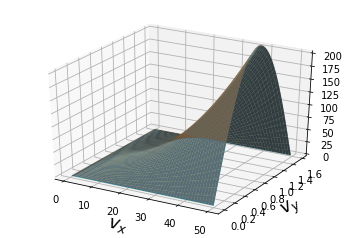

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
try:
    from scipy.constants import g, pi
except ImportError:
    g = 9.80665
    from math import pi
    
xx = np.linspace(0.5, 50, 200)
yy = np. linspace(1e-6, pi / 2, 200)

xx, yy = np.meshgrid(xx, yy)
points = np.stack([xx, yy], axis=2)

def s(coords):
    v, angle = coords
    return v * v * np.sin(2 * angle) / g
dist = np.apply_along_axis(s, -1, points)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx, yy, dist)
ax.plot_surface(xx, yy, dist + 1, alpha=0.3)  # верхняя граница ответа "попал" в тренировочных данных
ax.plot_surface(xx, yy, dist - 1, alpha=0.3)  # нижняя граница ответа "попал" в тренировочных данных
plt.xlabel(r"$v_x$", fontsize=18)
plt.ylabel(r"$v_y$", fontsize=18)
xlim = plt.xlim()  # чтобы построить следующий график в том же масштабе
ylim = plt.ylim()  # чтобы построить следующий график в том же масштабе
zlim = ax.get_zlim()
ax.set_zlim(0, 200)
plt.show()

        

In [34]:
from ipywidgets import *
@interact(layer1=IntSlider(min=0, max=10, continuous_update=False, description="Входной слой: ", value=6),
          layer2=IntSlider(min=0, max=10, continuous_update=False, description="Скрытый слой:"),
          layer3=IntSlider(min=0, max=10, continuous_update=False, description="Выходной слой: "),
          batch_size=BoundedIntText(min=1, max=len(data), value=10, description="Batch size: "),
          learning_rate=Dropdown(options=["0.01", "0.05", "0.1", "0.5", "1", "5", "10"], 
                                 description="Learning rate: ")
         )
def learning_curve_by_network_structure(layer1, layer2, layer3, batch_size, learning_rate):
    layers = [x for x in [input_count, layer1, layer2, layer3, output_count] if x > 0]
    nn = Network(layers, output=False)
    learning_rate=float(learning_rate)
    
    CER = []
    cost_train = []
    cost_test  = []
    for _ in range(150):
        nn.SGD(training_data=train, epochs=1, mini_batch_size=batch_size, eta=learning_rate)
        CER.append(1 - nn.evaluate(test) / len(test))
        cost_test.append(cost_function(nn, test, onehot=False))
        cost_train.append(cost_function(nn, train, onehot=True))
    
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1,2,1)
    plt.ylim(0, 1)
    plt.plot(CER)
    plt.title("Коэффициент ошибок классификации" )
    plt.ylabel("Процент неправильно идентифицированных наблюдений")
    plt.xlabel("Количество эпох")
    
    fig.add_subplot(1,2,2)
    plt.plot(cost_train, label="Тренировочная выборка", color="orange")
    plt.plot(cost_test, label="Тестовая выборка", color="blue")
    plt.title("График обучения", fontsize=18)
    plt.ylabel("Целевая функция",fontsize=18)
    plt.xlabel("Количество эпох", fontsize=18)
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=6, continuous_update=False, description='Входной слой: ', max=10), IntSlider(value=0, continuous_update=False, description='Скрытый слой:', max=10), IntSlider(value=0, continuous_update=False, description='Выходной слой: ', max=10), BoundedIntText(value=10, description='Batch size: ', max=500, min=1), Dropdown(description='Learning rate: ', options=('0.01', '0.05', '0.1', '0.5', '1', '5', '10'), value='0.01'), Output()), _dom_classes=('widget-interact',))